# STATE Training on Replogle-Nadig

This notebook walks you through training the STATE Transition (ST) model for context generalization. The notebook trains ST on the Replogle-Nadig dataset<sup>[1,2]</sup>, holding out a subset of perturbations in **hepg2** celltype.

The objective of this notebook is to demonstrate how to download the dataset from the cited sources, preprocess them and train a model. The notebook aims to follow the same steps as used in the [preprint](https://www.google.com/url?q=https%3A%2F%2Fwww.biorxiv.org%2Fcontent%2F10.1101%2F2025.06.26.661135).

#### References:
[1] J. M. Replogle, R. A. Saunders, A. N. Pogson, J. A. Hussmann, A. Lenail, A. Guna, L. Mascibroda, E. J. Wagner, K. Adelman, G. Lithwick-Yanai, et al. Mapping information-rich genotype-phenotype landscapes with genome-scale perturb-seq. Cell, 185(14):2559–2575, 2022. doi: [https://doi.org/10.1016/j.cell.2022.05.013](https://doi.org/10.1016/j.cell.2022.05.013)


[2] Nadig, A., Replogle, J.M., Pogson, A.N. et al. Transcriptome-wide analysis of differential expression in perturbation atlases. Nat Genet 57, 1228–1237 (2025). doi: [https://doi.org/10.1038/s41588-025-02169-3](https://doi.org/10.1038/s41588-025-02169-3)

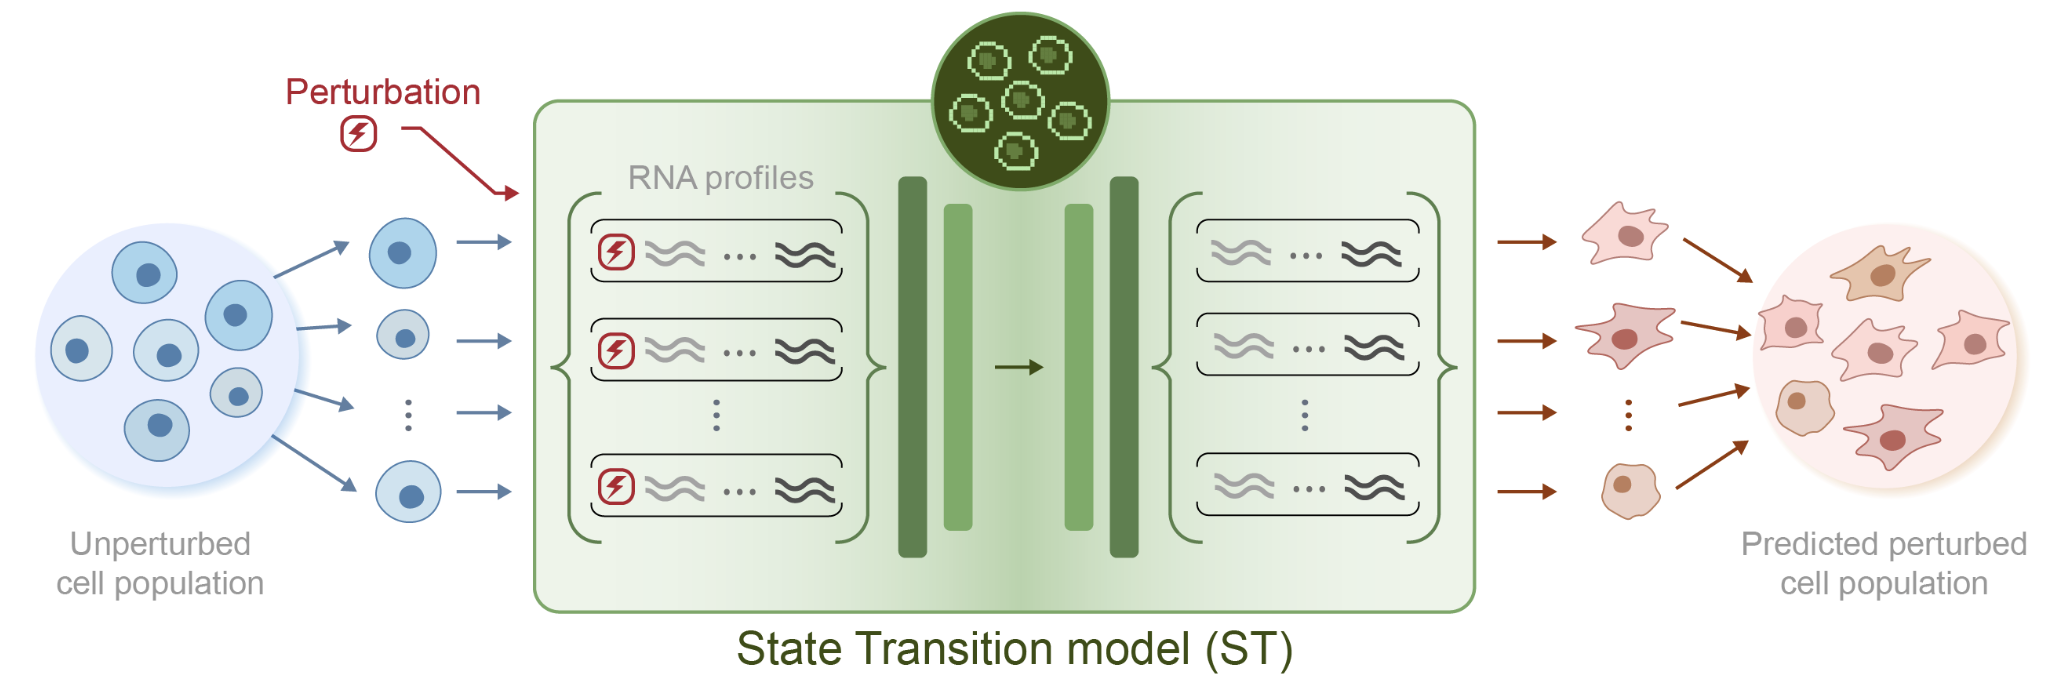

In [ ]:
! pip install scanpy --quiet

# Clone the repository

In [ ]:
# Clone the repository
! git clone https://github.com/ArcInstitute/state.git
%cd state

# Colab-specific config for pytorch lightning
import os
os.environ['MPLBACKEND'] = 'Agg'

fatal: destination path 'state' already exists and is not an empty directory.
/content/state
Already on 'aadduri/preprint'
Your branch is up to date with 'origin/aadduri/preprint'.


# Download the Replogle dataset

Downloading from data sources listed in the cited references.

In [ ]:
from huggingface_hub import snapshot_download
import os

# Define the repository ID and the local directory to save the files
repo_id = "arcinstitute/Replogle-Nadig-Preprint"
local_dir = "/content/data"

# Create the local directory if it doesn't exist
os.makedirs(local_dir, exist_ok=True)

# Download everything except the concatenated file
snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
    ignore_patterns=["replogle.h5ad"],
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

GSE264667_jurkat_raw_singlecell_01.h5ad:   0%|          | 0.00/9.37G [00:00<?, ?B/s]

GSE264667_hepg2_raw_singlecell_01.h5ad:   0%|          | 0.00/5.61G [00:00<?, ?B/s]

K562_essential_normalized_singlecell_01.(…):   0%|          | 0.00/10.7G [00:00<?, ?B/s]

rpe1_normalized_singlecell_01.h5ad:   0%|          | 0.00/8.70G [00:00<?, ?B/s]

'/content/data'

# Run Data Preprocessing in this Colab

In [ ]:
! uvx -q --from git+https://github.com/ArcInstitute/cell-load.git@cli_run_uv filter_on_target_knockdown --help

usage: filter_on_target_knockdown [-h] -o OUTPUT
                                  [--perturbation-column PERTURBATION_COLUMN]
                                  [--control-label CONTROL_LABEL]
                                  [--residual-expression RESIDUAL_EXPRESSION]
                                  [--cell-residual-expression CELL_RESIDUAL_EXPRESSION]
                                  [--min-cells MIN_CELLS] [--layer LAYER]
                                  [--var-gene-name VAR_GENE_NAME]
                                  [--preprocess]
                                  input

Filter cells based on on-target knockdown criteria

positional arguments:
  input                 Path to input AnnData file (.h5ad)

options:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        Path to output AnnData file (.h5ad)
  --perturbation-column PERTURBATION_COLUMN
                        Column in adata.obs holding perturbation identities
   

In [ ]:
# @title Filter the perturbations for knockdown efficacy, and preprocess the data as in the state paper. Note you need high-memory setting in the colab, or this will crash.

%%bash
set -euo pipefail
shopt -s nullglob

for f in /content/data/*.h5ad; do
  [[ "$f" == *_filtered.h5ad ]] && continue
  out="${f%.h5ad}_filtered.h5ad"
  echo "Processing: $f -> $out"
  uvx -q --from git+https://github.com/ArcInstitute/cell-load.git@main filter_on_target_knockdown \
    --perturbation-column "gene" \
    --control-label "non-targeting" \
    --output "$out" \
    --preprocess \
    "$f"
done

echo "Done. Filtered files:"
ls -1 /content/data/*_filtered.h5ad

Processing: /content/data/GSE264667_hepg2_raw_singlecell_01.h5ad -> /content/data/GSE264667_hepg2_raw_singlecell_01_filtered.h5ad


CalledProcessError: Command 'b'set -euo pipefail\nshopt -s nullglob\n\nfor f in /content/data/*.h5ad; do\n  [[ "$f" == *_filtered.h5ad ]] && continue\n  out="${f%.h5ad}_filtered.h5ad"\n  echo "Processing: $f -> $out"\n  uvx -q --from git+https://github.com/ArcInstitute/cell-load.git@main filter_on_target_knockdown \\\n    --perturbation-column "gene" \\\n    --control-label "non-targeting" \\\n    --output "$out" \\\n    --preprocess \\\n    "$f"\ndone\n\necho "Done. Filtered files:"\nls -1 /content/data/*_filtered.h5ad\n'' returned non-zero exit status 137.

In [ ]:
# @title Concatenate the data and compute HVGs (memory intensive for a Colab).
import scanpy as sc
import anndata as ad
import numpy as np
from scipy import sparse

# Load filtered files
files = [
    '/content/data/GSE264667_hepg2_raw_singlecell_01_filtered.h5ad',
    '/content/data/GSE264667_jurkat_raw_singlecell_01_filtered.h5ad',
    '/content/data/K562_essential_normalized_singlecell_01_filtered.h5ad',
    '/content/data/rpe1_normalized_singlecell_01_filtered.h5ad'
]

adatas = [ad.read_h5ad(f) for f in files]

# Concatenate with inner join on columns
x = ad.concat(adatas, join='inner')

# Make obs names unique
x.obs_names_make_unique()

# Compute top 2000 HVGs (data is already log-transformed)
sc.pp.highly_variable_genes(x, n_top_genes=2000)

# Set X_hvg obsm key
hvg_data = x.X[:, x.var['highly_variable']]
if sparse.issparse(hvg_data):
    hvg_data = hvg_data.toarray()
x.obsm['X_hvg'] = hvg_data

# Write output
x.write('/content/processed_data/replogle.h5ad')

# Alternatively, download from Hugging Face.

In [ ]:
# @title Download the output of the above section directly.

from huggingface_hub import snapshot_download
import os

repo_id = "arcinstitute/Replogle-Nadig-Preprint"
local_dir = "/content/processed_data"
os.makedirs(local_dir, exist_ok=True)

# Download ONLY the specified file
snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    local_dir=local_dir,
    local_dir_use_symlinks=False,          # optional: copy files instead of symlinks
    allow_patterns=["replogle.h5ad"],  # restrict to just this file
)

# Creating a TOML file for training

For this demonstration, we hold out a subset of perturbations from the cell type **hepg2** for validation and testing. We can precisely control which cell types and perturbations to holdout using a TOML file.

For zero-shot generalization across cellular contexts, we can add the cell types under the *zeroshot* label. In this demonstration, as in the [preprint](https://www.google.com/url?q=https%3A%2F%2Fwww.google.com%2Furl%3Fq%3Dhttps%253A%252F%252Fwww.biorxiv.org%252Fcontent%252F10.1101%252F2025.06.26.661135), we perform few-shot generalization, by holding out a subset of perturbations from the cell type to create the val and test set.

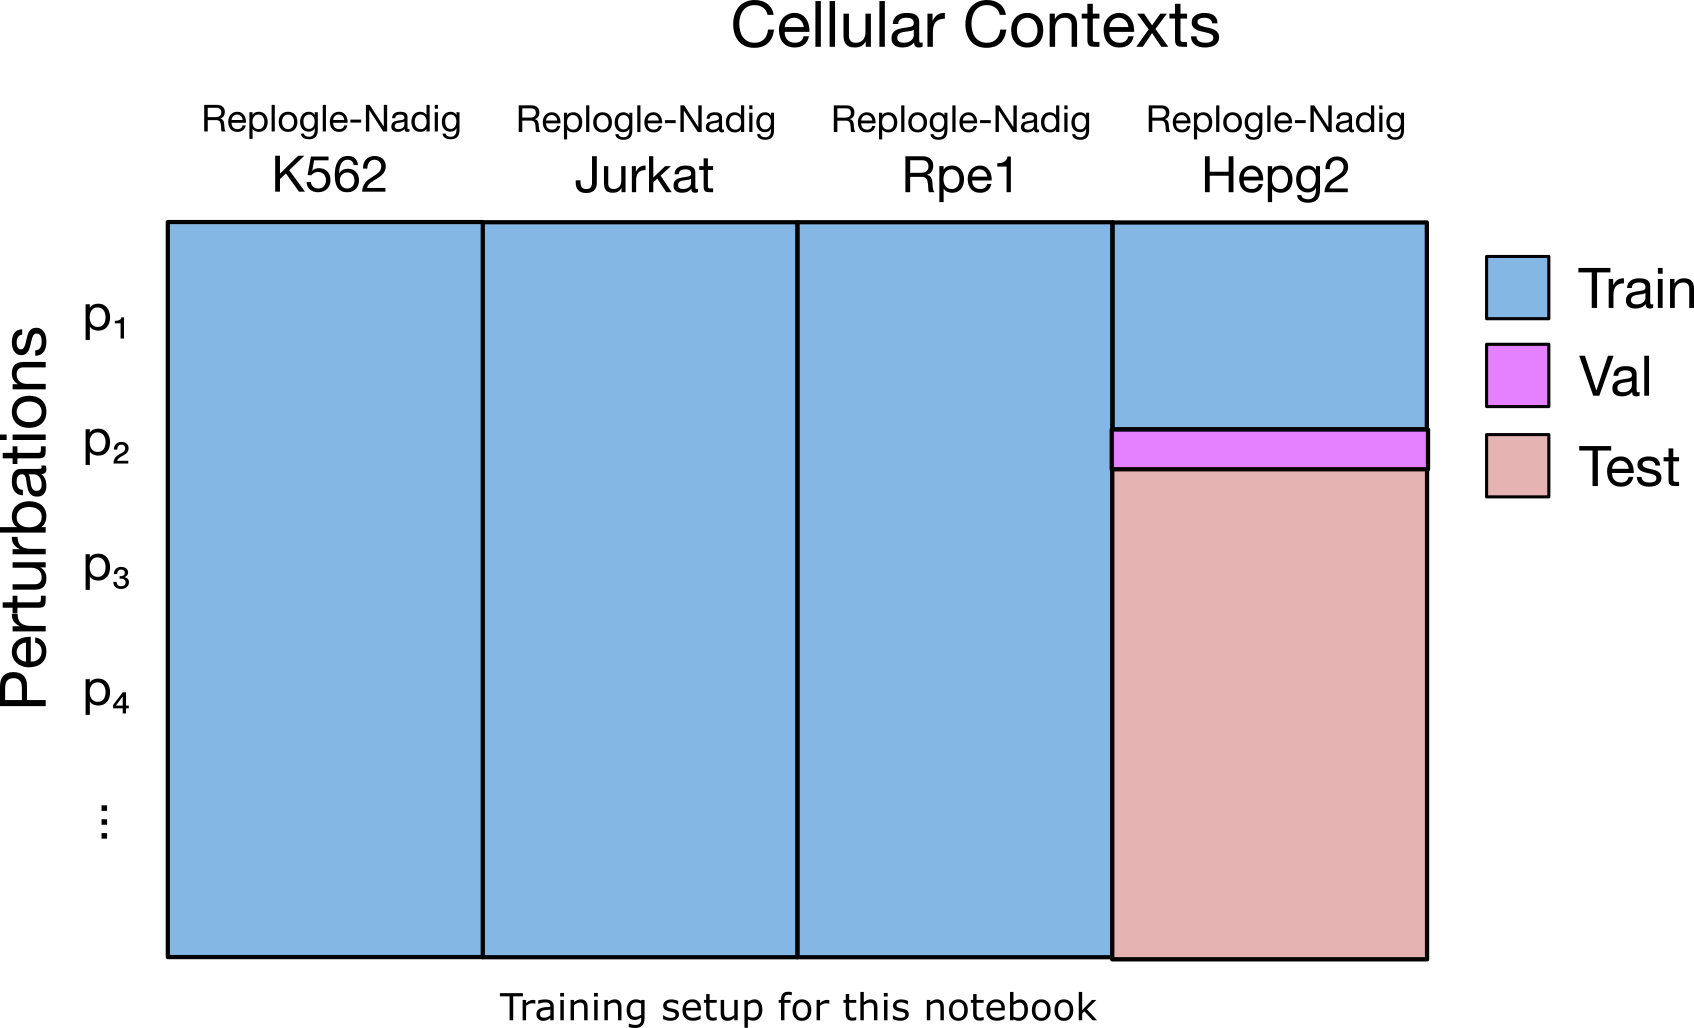

In [ ]:
! pip install toml -q

import toml

config = {
    # Dataset paths - maps dataset names to their directories
    "datasets": {
        "replogle_proper": "/content/processed_data"
    },
    # Training specifications
    # All cell types in a dataset automatically go into training (excluding zeroshot/fewshot overrides)
    "training": {
        "replogle_proper": "train"
    },
    # Zeroshot specifications - entire cell types go to val or test
    "zeroshot": {},
    # Fewshot specifications - explicit perturbation lists
    "fewshot": {
        "replogle_proper.hepg2": {
            "val": [
                'ATP6V1G1', 'TSEN34', 'TRAPPC8', 'NDUFS3', 'MRPS24', 'DNTTIP2',
                'WDR77', 'DHX36', 'RTCB', 'RPA3', 'CCDC144NL', 'NFKBIE', 'NFRKB',
                'TRMT10C', 'DIS3', 'CEP85', 'USP37', 'NPLOC4', 'UCHL5', 'NUP85',
                'DCTN1', 'GINS4', 'ZNF317', 'OR2T29', 'ZCCHC9', 'ALG11', 'PSMG4',
                'TUBD1', 'NDC1', 'HYPK', 'NASP', 'POLR3K', 'DESI1', 'TRAIP', 'ASCC3',
                'HCRTR1', 'ZW10', 'MIS12', 'LAMTOR4', 'PABPC4', 'NDUFA3', 'STAT5B',
                'PRDM4', 'GEMIN8', 'TRNP1', 'LCE1E', 'TP53RK', 'HNRNPH1', 'CYREN',
                'SMC2', 'TAF5', 'CABIN1', 'DCTN6', 'PPAN', 'GNL3', 'SMN2', 'NAA10',
                'THAP1', 'NOC4L', 'ZC3H4', 'C9orf78', 'SDHA', 'TERF2', 'RFC4', 'PEF1',
                'SRSF7', 'CRKL', 'INTS13', 'GCOM1', 'LTBP4', 'OR4N2', 'ZWINT', 'SNIP1',
                'HIST2H3D', 'DERL2', 'ANAPC1', 'POLR2G', 'E4F1', 'CWF19L2', 'MRGBP', 'SPG7',
                'CHMP5', 'CCDC115', 'ACD', 'HMGCS1', 'DNM1', 'NOL10', 'ZNF559', 'ZNF763',
                'XRCC3', 'NSF', 'SUPT5H', 'SLC1A5', 'MRPL36', 'RNMT', 'SNAPC1', 'CSNK2B',
                'KANSL2', 'PEX1', 'PITRM1', 'SPATA5', 'RPN1', 'CD8B', 'PSMD9'
            ],
            "test": [
                'TTF2', 'INO80B', 'ALG14', 'SNRNP27', 'MRPS14', 'UNCX', 'HUWE1', 'KAT7',
                'DIMT1', 'TCP1', 'DENR', 'NSRP1', 'VPS18', 'SRP19', 'CCDC86', 'SPOUT1',
                'CARF', 'VPS13D', 'UQCRFS1', 'LPIN1', 'PLK4', 'PRC1', 'ECT2', 'PTPN11',
                'CPSF1', 'PDCD5', 'TRAPPC1', 'PPWD1', 'DUT', 'EFR3A', 'LAMTOR3', 'GCLC',
                'MCM4', 'NHLRC2', 'WDR92', 'LENG8', 'SRP14', 'POLE2', 'KCNA10', 'RPL7L1',
                'FAM133B', 'ZNF676', 'COPS3', 'SMC5', 'HAUS1', 'CCDC78', 'NSUN4', 'ZNHIT6',
                'CCDC6', 'WDTC1', 'KDM5C', 'NLE1', 'NBPF15', 'WDR46', 'TPI1', 'SUGP1',
                'RABGGTA', 'MRPL9', 'GINS3', 'CCDC137', 'ZNF468', 'TIGD1', 'NOP2', 'MED26',
                'AKIRIN2', 'MRPL3', 'MED14', 'ATP6V1D', 'GPN3', 'MED7', 'ISCA2', 'RBM10',
                'TBCA', 'TMEM199', 'HEXIM1', 'RPL29', 'INTS3', 'RPS5', 'SF3A3', 'THOC1',
                'OPA1', 'INPPL1', 'ERAL1', 'COX15', 'SET', 'BRCA2', 'RANGAP1', 'RPL23A',
                'SUPT16H', 'LAMB1', 'UBQLN4', 'TBL3', 'TRMT6', 'C14orf178', 'CLP1', 'RPL35',
                'RPS25', 'CPSF2', 'SPAG7', 'RFC2', 'CENPC', 'RPL7', 'FNTA', 'TAF13', 'SNAPC5',
                'MRPS11', 'MEMO1', 'PGS1', 'HIST1H2AB', 'EPS8L1', 'TEFM', 'GNPNAT1', 'HNRNPDL',
                'TINF2', 'PCM1', 'ZNF492', 'PC', 'MRPS23', 'GMPPB', 'TMEM161B', 'EXOSC5',
                'PRPF39', 'SRP72', 'NOL11', 'RPS2', 'XPO5', 'SETX', 'GSPT1', 'AP2S1', 'SF1',
                'ZFP69B', 'TPRKB', 'TTC4', 'REXO2', 'RNF8', 'MRPL24', 'DDX47', 'PAM16', 'EMC4',
                'MASTL', 'KDM6A', 'PTPN23', 'AIFM1', 'GTF2H2', 'ARL4D', 'COG6', 'RPAP2', 'CWC15',
                'EIF1AX', 'EIF2S1', 'DCUN1D5', 'RCL1', 'ZBTB4', 'ALG1L', 'RPIA', 'GPS1', 'HAUS6',
                'NKAP', 'PTMA', 'ARHGAP11B', 'GMPS', 'USP10', 'NDC80', 'TMX2', 'SNRNP48', 'MRPL2',
                'CEP192', 'CACTIN', 'CDC6', 'CDC42', 'GLE1', 'RNPC3', 'CD2BP2', 'PPP4C', 'SP2',
                'CCDC59', 'CBLL1', 'USP14', 'ISG20L2', 'ZNF787', 'NUDCD3', 'NOL9', 'RFC1', 'GTF2B',
                'DDX52', 'ZBTB17', 'OGT', 'SKP1', 'POGZ', 'SEPSECS', 'BTAF1', 'HARS', 'SDE2', 'CEP68',
                'RARS', 'SRSF10', 'KDM1A', 'NDUFA6', 'NELFA', 'NOMO3', 'TUFM', 'SLU7', 'SPATA5L1',
                'ZNF506', 'FBLIM1', 'CDK9', 'SLC16A5', 'RFFL', 'PRRC2A', 'RAC1', 'COTL1', 'ARPC4',
                'DAD1', 'SMNDC1', 'ATP6V1E1', 'VPS29', 'ZNHIT3', 'FYN', 'NUTF2', 'SKP2', 'ZNF407',
                'MED29', 'U2SURP', 'GSK3B', 'HIST1H2AE', 'UTP6', 'GTF2H4', 'CLCC1', 'SNF8', 'UTP15',
                'DNAJC11', 'RAB6A', 'TMEM240', 'ITGB1BP1', 'BYSL', 'CDAN1', 'MIPEP', 'DHX16', 'HDAC3',
                'SMG7', 'CHMP1A', 'FAU', 'MRPL13', 'CCP110', 'TARS2', 'DDX24', 'MYB', 'TTK', 'BCAR1',
                'RPP21', 'ERVW-1', 'SMAGP', 'MED19', 'HIST1H2BJ', 'SRRM2', 'GTF3C6', 'ZC3H13', 'PPP1R11',
                'CMTR2', 'QRSL1', 'RPL26', 'EIF2B1', 'MOK', 'NUB1', 'E2F6', 'PFDN1', 'NOL7', 'TFRC',
                'CMTR1', 'UBA2', 'MTREX', 'HINFP', 'MVD', 'NELFE', 'PDCD7', 'WBP1', 'SMG8', 'GET3',
                'OR4K1', 'RPP14', 'COG3', 'PELP1', 'C1D', 'TFB1M', 'MRPS16', 'RBM42', 'HIST2H2AA3',
                'NOL6', 'ZDHHC7', 'DDX20', 'SEC61G', 'CHMP3', 'VARS2', 'RPS21', 'TNNT2', 'CCDC144A',
                'YJEFN3', 'MAT2A', 'GSDMA', 'TXN', 'MEN1', 'ATP6V1F', 'NCAPD2', 'CS', 'MED1', 'MRPS22',
                'NVL', 'BRIX1', 'MOCS3', 'EMC1', 'POTEI', 'SSBP1', 'TULP1', 'AGBL5', 'PAXBP1', 'IARS2',
                'LAS1L', 'CT45A5', 'SOD2', 'SDHC', 'GTF2H3', 'UBAP1', 'PDRG1', 'INTS12', 'PAK1IP1',
                'MTCP1', 'RPS26', 'ZC3H18', 'WARS', 'RUVBL2', 'KRTAP4-2', 'NBPF12', 'ANAPC5', 'OSTC',
                'GPN2', 'HMGB3', 'POU5F1B', 'RPL28', 'CNOT2', 'EIF3F', 'MRPL39', 'PGK1', 'PDCD2',
                'NCBP1', 'MDN1', 'MRM1', 'ABHD11', 'GART', 'CENPN', 'MT2A', 'FGFR1OP', 'AARS2',
                'INTS10', 'MED9', 'HSD17B10', 'RRM1', 'DNM1L', 'COMTD1', 'SRFBP1', 'ADNP2', 'ZNF335',
                'AHCY', 'UBE2N', 'CUL1', 'ANKRD49', 'C7orf26', 'TBC1D3', 'TXNL4B', 'PES1', 'CPSF3',
                'DNAJA1', 'CNOT3', 'MARS2', 'PPIL2', 'CCND1', 'UTP11', 'TMEM214', 'NDUFB4', 'RPL26L1',
                'ZC3H8', 'MAU2', 'PRDM8', 'CENPT', 'SYF2', 'NDOR1', 'TADA1', 'CSNK1A1', 'GAR1', 'ORC5',
                'PIAS1', 'HSPD1', 'MED12', 'RMI1', 'ACTR8', 'DDX27', 'EIF2S3', 'ARHGAP6', 'MSL1',
                'CNOT11', 'COX17', 'COPS2', 'PRELID3B', 'TOX4', 'DDX18', 'URB1', 'WDHD1', 'TIMELESS',
                'TAF6', 'CHCHD4', 'RPS8', 'CDC20', 'IFITM3', 'TUBGCP3', 'NAA35', 'MCM2', 'C19orf53',
                'DNM2', 'TM7SF2', 'SNRPC', 'PPP6C', 'U2AF1', 'DNAJC17', 'RPS14', 'SDHAF2', 'RHPN1',
                'EP400', 'HIST1H2BL', 'DOLK', 'KIF18B', 'LARS', 'PRPF18', 'SNRPA', 'CRCP', 'SARS',
                'IWS1', 'MED8', 'MED10', 'SLC9B1', 'PMF1', 'ABCB7', 'PPIL4', 'NRBP1', 'RPF2', 'BMS1',
                'SRRM1', 'FAM102B', 'MED17', 'TRMT112', 'UQCRB', 'TICRR', 'ZNF720', 'UPF3A', 'DRG1',
                'PTGR2', 'BAP1', 'PHB', 'SAMD4B', 'SNRNP25', 'OSBP', 'DBR1', 'GPR61', 'MRPS28', 'BRK1',
                'RBMXL1', 'ZMAT5', 'TMEM127', 'NUDC', 'NOM1', 'EIF2B5', 'TRA2B', 'TAF10', 'GTF3C3', 'YRDC',
                'SUPV3L1', 'COG4', 'CLPB', 'STRIP1', 'NUP54', 'RPL37A', 'CNIH4', 'LMO2', 'UTP3', 'RPS20',
                'NAA15', 'NBAS', 'PTEN', 'GINS2', 'PRPF38B', 'POP1', 'CCND3', 'COG2', 'CASP8AP2', 'SF3B5',
                'MIS18BP1', 'YPEL5', 'ZMAT2', 'SLC25A42', 'HAUS7', 'NFYB', 'BAG6', 'MVK', 'CPSF6',
                'UQCRH', 'PSME2', 'FAM72D', 'PHB2', 'CHTF8', 'PPP1R8', 'FAM32A', 'CBFA2T3', 'FAM229A',
                'RNF31', 'INO80E', 'GABPB1', 'MCL1', 'MRPL43', 'RRN3', 'RNASEH2C', 'TUBE1', 'TUBA1C',
                'RAB18', 'INTS11', 'SHQ1', 'UROD', 'FEN1', 'PWP2', 'TP53I13', 'CHMP7', 'DPH1', 'MARS',
                'TOP1', 'POLD3', 'CPNE7', 'NOS1AP', 'VEZT', 'TFDP1', 'DCTN2', 'RPL30', 'DHPS', 'BUD13',
                'C6orf15', 'CEP97', 'GFER', 'INTS2', 'TSEN2', 'ARGLU1', 'ATP5F1C', 'IPO13', 'EXOC8',
                'IST1', 'NUP88', 'EIF3G', 'WDR82', 'MLLT6', 'ORC3', 'NUP133', 'WDR70', 'STIL', 'PAF1',
                'PPP1CB', 'BCLAF1', 'MYBBP1A', 'CLASRP', 'ZNF253', 'ZRSR2', 'MRPL35', 'HIST1H2BC',
                'POLR1E', 'ACTR1B', 'HSP90B1', 'MYBL2', 'NFS1', 'CCT7', 'YARS2', 'CYFIP1', 'ABCE1',
                'FBXW7', 'NEDD8-MDP1', 'EXOC7', 'TSFM', 'MED21', 'INTS14', 'KIN', 'BARD1', 'C9orf16',
                'LTBP3', 'H2AFZ', 'RFT1', 'HARS2', 'VPS54', 'XRN1', 'RNF20', 'FBXO42', 'POLA2', 'CLTC',
                'VPS51', 'ANAPC13', 'RRP15', 'SART3', 'ANAPC10', 'HOXA3', 'CUL3', 'RSL24D1', 'MMGT1',
                'MRPL46', 'DKC1', 'HEATR1', 'POLL', 'TMEM242', 'EXOSC4', 'POLR3F', 'RPS28', 'DNLZ',
                'NANOG', 'CCNQ', 'NIFK', 'LUC7L3', 'PSAT1', 'INTS6', 'ESPN', 'CDK2', 'ESF1', 'HSPH1', 'RNGTT'
            ]
        }
    }
}

output_filename = '/content/hepg2.toml'
with open(output_filename, 'w') as f:
    toml.dump(config, f)

# Installation and Training

In [ ]:
# @title Set Weights and Biases Entity for tracking
%cd state
entity = "arcinstitute" # @param {"type":"string","placeholder":"arcinstitute"}
! sed -i 's|entity: your_entity_name|entity: {entity}|g' src/state/configs/wandb/default.yaml

In [ ]:
# install the package
! uv sync

In [ ]:
# Make sure 0.7.11 is installed
! uv add cell-load>=0.7.11 --refresh

In [ ]:
# State TX Training Command
# This setups up training for State using HVG featurizations of the cell.

! uv run state tx train \
  data.kwargs.toml_config_path="/content/hepg2.toml" \
  data.kwargs.num_workers=4 \
  data.kwargs.output_space="gene" \
  data.kwargs.batch_col="gem_group" \
  data.kwargs.pert_col="gene" \
  data.kwargs.cell_type_key="cell_line" \
  data.kwargs.control_pert="non-targeting" \
  training.max_steps=80000 \
  training.ckpt_every_n_steps=2000 \
  training.batch_size=64 \
  training.lr=1e-3 \
  model.kwargs.cell_set_len=64 \
  model.kwargs.hidden_dim=128 \
  model.kwargs.batch_encoder=True \
  model=state \
  wandb.tags="[replogle_run]" \
  output_dir="test_replogle" \
  name="hepg2_holdout"

# Testing model on holdout data

The predict function runs inference on the holdout test data, followed by running [cell-eval](https://github.com/ArcInstitute/cell-eval) on this data. This function can be used to obtain the set of metrics described in the [preprint](https://www.google.com/url?q=https%3A%2F%2Fwww.google.com%2Furl%3Fq%3Dhttps%253A%252F%252Fwww.biorxiv.org%252Fcontent%252F10.1101%252F2025.06.26.661135).

In [ ]:
! uv run state tx predict -h

In [ ]:
# State TX Prediction Command
# This runs inference as well as cell-eval on the holdout test data, as chosen using the .toml file.

! uv run state tx predict --output_dir "test_replogle/hepg2_holdout" --checkpoint "last.ckpt"